# Data Understanding and Modeling Introduction
---
Uma vez definido o problema a ser resolvido, é preciso conhecer o dado. Ao investigar o dataset é possível até mesmo que o problema original seja repensado, uma vez que um conhecimento maior sobre o dado pode faciliar a visualização de novas oportunidades e possíveis deficiências do conjunto.
##### Este notebook tem como objetivo explorar os dados fornecidos com o objetivo de prepara-lo para utilização no treinamento de um modelo de machine learning. A exploração do dado indica os tratamentos que devem ser aplicados para o treinamento de tal modelo. Este notebook descreve possíveis formas de tratar este dado antes do treinamento, mas não é uma descrição exaustiva - diferentes abordagens podem ser utilizadas.

## Análise Geral
---

In [1]:
#Imports 
import pandas as pd
import seaborn as sns

In [2]:
#Load data 
train_data_path = "./data/train.csv"
test_data_path = "./data/test.csv"

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [3]:
#Take a first look at the data
#Train set
print("Train data has %s columns and %s rows" % (train_df.shape[1], train_df.shape[0]))
print("Train data sample:")
train_df.head()

Train data has 12 columns and 891 rows
Train data sample:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Take a first look at the data
#Test set
print("Train data has %s columns and %s rows" % (test_df.shape[1], test_df.shape[0]))
print("Train data sample:")
test_df.head()

Train data has 11 columns and 418 rows
Train data sample:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Uma análise inicial nos permite identificar coerência entre os dois conjuntos - treino e teste. O conjunto de teste possui 11 atributos, todos presentes no conjunto de treinamento. O conjunto de treino possui uma feature a mais, que é o target, o que já era esperado.

O conjunto Titanic foi fornecido pelo Kaggle já com uma separação entre treino e teste. Na maioria dos projetos reais os analistas são responsáveis por esta separação.
Ao realizar a divisão dos conjuntos é importante atentar para os seguintes pontos:
* Um determinado exemplo deve pertencer apenas a um dos conjuntos. No caso deste dataset, por exemplo, um passageiro que está no conjunto de treinamento não pode estar no conjunto de testes, uma vez que isso pode mascarar o real resultado do modelo.
* Se tratando de um problema de classificacão, como é o caso, deve-se preservar a distribuição de classes entre os conjuntos.

Como conjunto inicial, é válido também remover os exemplos duplicados dentro de cada conjunto. A duplicação de um exemplo (ou oversampling) pode ser utilizada mais tarde como forma de balanceamento de classes, caso necessário. Essa remoção deve ser feita antes da separação dos conjuntos.

Como o conjunto de teste fornecido não possui a coluna target, aqui assume-se que os requisitos de distribuicão e balanceamento de classes são atendidos.

Exemplos duplicados, se existirem, também não serão removidos do conjunto de teste, para que o resultado possa ser submetido no Kaggle.

In [5]:
#Check for duplicates on train set
train_df.duplicated().value_counts()

False    891
dtype: int64

In [6]:
#Check for duplicates on test set
test_df.duplicated().value_counts()

False    418
dtype: int64

Como nenhum dos conjuntos possui linhas iguais (a princípio), nenhuma linha será excluída.

In [7]:
#Verify class distribution on train set
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

O conjunto se apresenta relativamente balanceado, com 61.6% pertencendo à classe majoritária (não sobreviveu) e 38.4% pertencente à classe minoritária (sobreviveu). Técnicas de balanceamento podem beneficiar modelos mais facilmente afetados por desbalanceamentos. O dado é suficientemente balanceado para que certos modelos atinjam bons resultados sem um balanceamento prévio.

In [9]:
#Verify if there are rows on both datasets
train_df.merge(test_df, on=["PassengerId"])

,PassengerId,Survived,Pclass_x,Name_x,Sex_x,Age_x,SibSp_x,Parch_x,Ticket_x,Fare_x,...,Pclass_y,Name_y,Sex_y,Age_y,SibSp_y,Parch_y,Ticket_y,Fare_y,Cabin_y,Embarked_y


O merge do pandas com parâmetros padrões retorna linhas iguais para colunas presentes nos dois dataframes. Como o retorno foi vazio podemos concluir que os dados não se repetem nos conjuntos.

## Data Leakage
---
Em machine learning, data leakage é uma situação onde uma feature contém informação sobre o atributo target ou quando uma feature que não estará disponível durante a etapa de predição é usado para treinamento ou ainda quando um tratamento é realizado no dado de forma a fornecer conhecimento entre os conjuntos de treinamento e validação/teste.

Aqui é destacada a importância da etapa de business understanding em um processo de aprendizagem de máquina. É necessário conhecer o fluxo de informacão para poder definir os atributos que estarão disponíveis para treinamento. Estes precisam ser iguais aos que estarão disponíveis no momento da predição.

Data leakage pode ser inerente do dados fornecido ou proviente do tratamente utilizado. Nesta etapa será verificada a existência de um leakage prévio, onde uma determinada feature corresponde ao target definido.

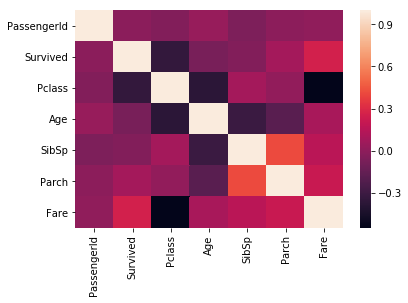

In [10]:
#Verify correlation between features
correlation_matrix  = train_df.corr()
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

Analisando a matriz é possível perceber que Pclass e Fare são as features que se relacionam mais fortemente com Survived, mas apesar da relação existir, ela não é forte o suficiente para suspeitar de um leakage.

SibSp e Parch também possuem influência significativa.

Nota-se que as únicas features levadas em consideração no cálculo foram as features numéricas. Ao finalizar os tratamentos dos atributos é importante repetir a análise para garantir resultado coerentes.

## Análise de Features
---
Uma vez analisado o dataset de forma genérica, o próximo passo é a análise detalhada de suas features. A depender do problema, a análise individual dos atributos de um conjunto de dados pode ser inviável (quando estes forem muitos, por exemplo) ou não necessária (no caso de uma série temporal, por exemplo).


#### PassagerId
Esta feature aparenta ser um identificador único de um passageiro. Caso isso seja verdade, ela não deve ser usada na predição pois não representa uma característica do indivíduo.

In [11]:
#Verify number of unique values 
unique_values_passenger_id = train_df["PassengerId"].unique().shape[0]
unique_passengers_train = train_df.shape[0]
print("Unique ID values in train: %s" % unique_values_passenger_id)
print("Unique passengers in train: %s" % unique_passengers_train)

Unique ID values in train: 891
Unique passengers in train: 891


In [12]:
#Verify number of unique values in test 
unique_values_passenger_id_test = test_df["PassengerId"].unique().shape[0]
unique_passengers_test = test_df.shape[0]
print("Unique ID values in train: %s" % unique_values_passenger_id_test)
print("Unique passengers in train: %s" % unique_passengers_test)

Unique ID values in train: 418
Unique passengers in train: 418


Os IDs são únicos tanto no treinamento como no teste, confirmando a suposição inicial.

#### PClass
De acordo com a descrição do dataset, PClass corresponde à classe do passageiro durante a viagem. Já foi verificado que este é um atributo que possui forte relação com o target. 

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64


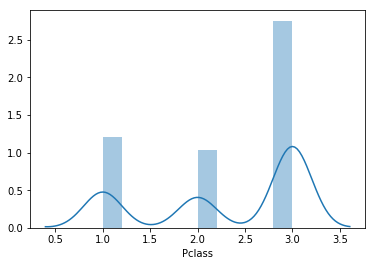

In [13]:
#Verify Distribution
print(train_df["Pclass"].value_counts(normalize=True, dropna=False))
sns.distplot(train_df["Pclass"])

O atributo já está em formato numérico e não apresenta missing values. A princípio não necessita de tratamento. Um possível ajuste seria a normalização, que será avaliada quando todas as features forem numérias.

#### Name
Name é um atributo em formato de texto. Para analisa-lo é preciso entender o formato em que o texto é apresentado.

In [14]:
#Look at text format
print(train_df["Name"].head(n=10))

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object


O formato do nome parece seguir o padrão SOBRENOME, TÍTULO NOME. O padrão é aparetemente quebrado quando o título é Mrs. Ester casos merecem uma investigação mais profunda.

In [15]:
print(train_df["Name"][train_df["Name"].str.startswith("Futrelle")])

3      Futrelle, Mrs. Jacques Heath (Lily May Peel)
137                     Futrelle, Mr. Jacques Heath
Name: Name, dtype: object


In [16]:
print(train_df["Name"][train_df["Name"].str.startswith("Cumings")])
print(test_df["Name"][test_df["Name"].str.startswith("Cumings")])

1    Cumings, Mrs. John Bradley (Florence Briggs Th...
Name: Name, dtype: object
234    Cumings, Mr. John Bradley
Name: Name, dtype: object


O nome em parênteses aparenta ser o nome real da passageira enquanto o nome atribuido seria, possivelmente, do marido.

O tratamento de dados de texto requer uma atenção maior. A utilizacão deste tipo de dado pode se dar de algumas formas:
* O mapeamento do texto completo, ou expressões nele contidas em atributos numéricos. Esta abordagem normalmente transforma uma única feature em dezenas ou até centenas de outras features, a depender do método escolhido e do tamanho do vocabulário daquele campo.
* A extração de informação do texto de forma a criar novas features categórcias. Um exemplo para o caso do Titanic seria criar um atributo que representasse o título do passageiro.

Um possível problema na extração do título está na possibilidade do conjunto de teste possuir um valor de título diferente daqueles encontrados no treinamento. Uma forma de lidar com isso é introduzir uma categorial extra, que representa a ausência de categoria ou uma categoria desconhecida.

#### Sex
Representa o sexo do passageiro. Se trata de uma feature categórica, que pode assumir um de dois valores: homem ou mulher.

In [17]:
#Verify Distribution
print(train_df["Sex"].value_counts(normalize=True, dropna=False))

male      0.647587
female    0.352413
Name: Sex, dtype: float64


À bordo do Titanic existiam mais homens do que mulheres. 

Por se tratar de uma feature categórica, existem dois tipos de tratamento que podem ser adotados:
* Label Encoder, onde cada valor possível recebe um valor numérico que o represente (Exemplo: 0 - Homem, 1 - Mulher).
* One-Hot encoding, onde são criadas tantas features quanto valores para o atributo original (Exemplo: a feature Sex é substituída por dois novos atributos: Homem e Mulher). 

O tipo de tratamento dado pode depender, por exemplo, do algoritmo usado e da relação entre as categorias. Considerar homem como 0 e mulher como 1, por exemplo, pode levar um algoritmo a inferir que mulher é o estado sucessor do homem, quando esta relação não é verdadeira. 

O atributo não possui missing values. 

#### Age
Representa a idade do passageiro.

NaN       0.198653
 24.00    0.033670
 22.00    0.030303
 18.00    0.029181
 28.00    0.028058
 19.00    0.028058
 30.00    0.028058
 21.00    0.026936
 25.00    0.025814
 36.00    0.024691
 29.00    0.022447
 32.00    0.020202
 26.00    0.020202
 35.00    0.020202
 27.00    0.020202
 16.00    0.019080
 31.00    0.019080
 34.00    0.016835
 23.00    0.016835
 33.00    0.016835
 20.00    0.016835
 39.00    0.015713
 17.00    0.014590
 42.00    0.014590
 40.00    0.014590
 45.00    0.013468
 38.00    0.012346
 50.00    0.011223
 2.00     0.011223
 4.00     0.011223
            ...   
 28.50    0.002245
 63.00    0.002245
 0.83     0.002245
 30.50    0.002245
 70.00    0.002245
 57.00    0.002245
 0.75     0.002245
 13.00    0.002245
 59.00    0.002245
 10.00    0.002245
 64.00    0.002245
 40.50    0.002245
 45.50    0.002245
 32.50    0.002245
 20.50    0.001122
 24.50    0.001122
 0.67     0.001122
 70.50    0.001122
 0.92     0.001122
 74.00    0.001122
 34.50    0.001122
 14.50    0.

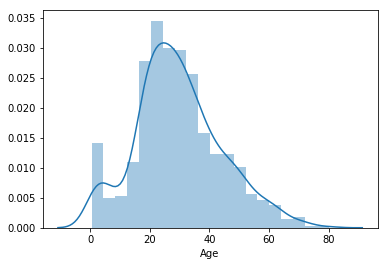

In [18]:
#Verify Distribution
print(train_df["Age"].value_counts(normalize=True, dropna=False))
sns.distplot(train_df["Age"].dropna())

Quase 20% dos passageiros do conjunto de treinamento não possuem registro de idade. A ausência de dados em um atributo numérico pode ser tratada de várias formas:
* Preenchimento com a média de idade, mediana e afins. É possível neste caso considerar todos os passageiros, por exemplo, ou apenas aqueles do mesmo sexo ou mesma classe.
* Eliminacão das linhas com dados faltantes.
* Preenchimento com um valor fixo, como 0, quando este fizer sentido para o atributo.

A idade já é um valor numérico com uma relação sequencial entre seus valores e por isso não necessita de mais tratamentos além do preenchimento de missing values.

#### SibSp
Representa o número de irmãos ou cônjuges de um passageiro que estavam presentes no Titanic.

0    0.682379
1    0.234568
2    0.031425
4    0.020202
3    0.017957
8    0.007856
5    0.005612
Name: SibSp, dtype: float64


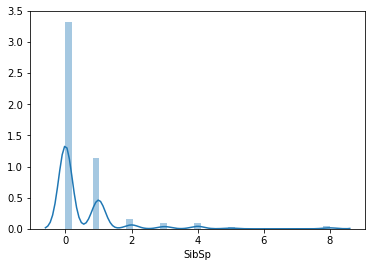

In [19]:
#Verify Distribution
print(train_df["SibSp"].value_counts(normalize=True, dropna=False))
sns.distplot(train_df["SibSp"].dropna())

A maoiria dos passageiros não tinha irmãos ou cônjiges a bordo do Titanic.

SibSp já é um valor numérico com uma relação sequencial entre seus valores e por isso não necessita de mais tratamentos. Também não possui missing values.

#### Parch
Representa o número de pais e/ou filhos de um passageiro que estavam presentes no Titanic.

0    0.760943
1    0.132435
2    0.089787
5    0.005612
3    0.005612
4    0.004489
6    0.001122
Name: Parch, dtype: float64


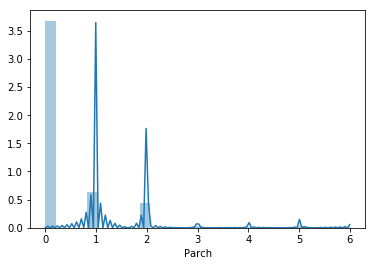

In [20]:
#Verify Distribution
print(train_df["Parch"].value_counts(normalize=True, dropna=False))
sns.distplot(train_df["Parch"].dropna())

A maoiria dos passageiros não tinha filhos ou pais a bordo do Titanic.

Parch já é um valor numérico com uma relação sequencial entre seus valores e por isso não necessita de mais tratamentos. Também não possui missing values.

#### Ticket
Ticket representa o número do ticket do passageiro. Assim como PassengerID este pode ser um identificador único e deve ser descosiderado se for o caso.

In [21]:
#Verify number of unique values 
unique_values_ticket_train = train_df["Ticket"].unique().shape[0]
unique_tickets_train = train_df.shape[0]
print("Unique Ticket values in train: %s" % unique_values_ticket_train)
print("Unique passengers in train: %s" % unique_tickets_train)

Unique Ticket values in train: 681
Unique passengers in train: 891


In [22]:
#Verify number of unique values 
unique_values_ticket_test = test_df["Ticket"].unique().shape[0]
unique_tickets_train = test_df.shape[0]
print("Unique Ticket values in train: %s" % unique_values_ticket_test)
print("Unique passengers in train: %s" % unique_tickets_train)

Unique Ticket values in train: 363
Unique passengers in train: 418


In [23]:
#Verify missing values in Tickets
print(train_df["Ticket"].value_counts(dropna=False))
print(train_df["Ticket"].isna().sum())

347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
347088              6
382652              5
S.O.C. 14879        5
LINE                4
113760              4
113781              4
W./C. 6608          4
19950               4
349909              4
2666                4
347077              4
4133                4
17421               4
PC 17757            4
PC 17572            3
230080              3
345773              3
F.C.C. 13529        3
110152              3
PC 17760            3
239853              3
347742              3
C.A. 34651          3
SC/Paris 2123       3
PC 17582            3
                   ..
S.C./A.4. 23567     1
28228               1
392091              1
2680                1
2649                1
370372              1
113783              1
SOTON/O2 3101272    1
349227              1
A/5. 2151           1
2664                1
248698              1
394140              1
234604              1
SW/PP 751 

In [24]:
#Verify passengers with the same ticket values
print(train_df[train_df["Ticket"] == '1601'])

     PassengerId  Survived  Pclass             Name   Sex   Age  SibSp  Parch  \
74            75         1       3    Bing, Mr. Lee  male  32.0      0      0   
169          170         0       3    Ling, Mr. Lee  male  28.0      0      0   
509          510         1       3   Lang, Mr. Fang  male  26.0      0      0   
643          644         1       3  Foo, Mr. Choong  male   NaN      0      0   
692          693         1       3     Lam, Mr. Ali  male   NaN      0      0   
826          827         0       3     Lam, Mr. Len  male   NaN      0      0   
838          839         1       3  Chip, Mr. Chang  male  32.0      0      0   

    Ticket     Fare Cabin Embarked  
74    1601  56.4958   NaN        S  
169   1601  56.4958   NaN        S  
509   1601  56.4958   NaN        S  
643   1601  56.4958   NaN        S  
692   1601  56.4958   NaN        S  
826   1601  56.4958   NaN        S  
838   1601  56.4958   NaN        S  


In [25]:
#Verify passengers with the same ticket values
print(train_df[train_df["Ticket"] == 'CA 2144'])

     PassengerId  Survived  Pclass                                     Name  \
59            60         0       3       Goodwin, Master. William Frederick   
71            72         0       3               Goodwin, Miss. Lillian Amy   
386          387         0       3          Goodwin, Master. Sidney Leonard   
480          481         0       3           Goodwin, Master. Harold Victor   
678          679         0       3  Goodwin, Mrs. Frederick (Augusta Tyler)   
683          684         0       3              Goodwin, Mr. Charles Edward   

        Sex   Age  SibSp  Parch   Ticket  Fare Cabin Embarked  
59     male  11.0      5      2  CA 2144  46.9   NaN        S  
71   female  16.0      5      2  CA 2144  46.9   NaN        S  
386    male   1.0      5      2  CA 2144  46.9   NaN        S  
480    male   9.0      5      2  CA 2144  46.9   NaN        S  
678  female  43.0      1      6  CA 2144  46.9   NaN        S  
683    male  14.0      5      2  CA 2144  46.9   NaN        S 

In [26]:
#Verify passengers with the same ticket values
print(train_df[train_df["Ticket"] == '347082'])

     PassengerId  Survived  Pclass  \
13            14         0       3   
119          120         0       3   
541          542         0       3   
542          543         0       3   
610          611         0       3   
813          814         0       3   
850          851         0       3   

                                                  Name     Sex   Age  SibSp  \
13                         Andersson, Mr. Anders Johan    male  39.0      1   
119                  Andersson, Miss. Ellis Anna Maria  female   2.0      4   
541               Andersson, Miss. Ingeborg Constanzia  female   9.0      4   
542                  Andersson, Miss. Sigrid Elisabeth  female  11.0      4   
610  Andersson, Mrs. Anders Johan (Alfrida Konstant...  female  39.0      1   
813                 Andersson, Miss. Ebba Iris Alfrida  female   6.0      4   
850            Andersson, Master. Sigvard Harald Elias    male   4.0      4   

     Parch  Ticket    Fare Cabin Embarked  
13       5  347082

In [27]:
#Verify passengers with the same ticket values
print(train_df[train_df["Ticket"] == 'PC 17757'])

     PassengerId  Survived  Pclass  \
380          381         1       1   
557          558         0       1   
700          701         1       1   
716          717         1       1   

                                                  Name     Sex   Age  SibSp  \
380                              Bidois, Miss. Rosalie  female  42.0      0   
557                                Robbins, Mr. Victor    male   NaN      0   
700  Astor, Mrs. John Jacob (Madeleine Talmadge Force)  female  18.0      1   
716                      Endres, Miss. Caroline Louise  female  38.0      0   

     Parch    Ticket     Fare    Cabin Embarked  
380      0  PC 17757  227.525      NaN        C  
557      0  PC 17757  227.525      NaN        C  
700      0  PC 17757  227.525  C62 C64        C  
716      0  PC 17757  227.525      C45        C  


O número do ticket não é único por passageiro, como era esperado. A menor quantidade de valores para os tickets também não se deve a presença de missing values, como é possível ver a partir da contagem de valores faltantes.

Investiga-se então os passageiros que possuem um mesmo valor de Ticket. Para alguns destes valores, os passageiros parecem pertencer à mesma família, o que não é verdade para outros. O valor pago por um Ticket de mesma numeração é o mesmo para todos os passageiros, sendo esse o compartamento esperado.

Esta inconsistência leva a acreditar que este não seja um campo relevante para a predição. A confirmação desta observação só poderá ocorrer após a realização de testes e treinamentos de modelos.

Para usa este tipo de dado em um modelo, podemos trata-lo como dado categórico ou ainda realizar um tratamento de texto com a remoção de certos caracteres ou a criação de novas features (separando letras de dígitos, por exemplo).

#### Fare
Fare representa o valor pago pelo passageiro pelo Ticket.

8.0500      0.048260
13.0000     0.047138
7.8958      0.042649
7.7500      0.038159
26.0000     0.034792
10.5000     0.026936
7.9250      0.020202
7.7750      0.017957
26.5500     0.016835
0.0000      0.016835
7.2292      0.016835
7.8542      0.014590
8.6625      0.014590
7.2500      0.014590
7.2250      0.013468
16.1000     0.010101
9.5000      0.010101
24.1500     0.008979
15.5000     0.008979
56.4958     0.007856
52.0000     0.007856
14.5000     0.007856
14.4542     0.007856
69.5500     0.007856
7.0500      0.007856
31.2750     0.007856
46.9000     0.006734
30.0000     0.006734
7.7958      0.006734
39.6875     0.006734
              ...   
7.1417      0.001122
42.4000     0.001122
211.5000    0.001122
12.2750     0.001122
61.1750     0.001122
8.4333      0.001122
51.4792     0.001122
7.8875      0.001122
8.6833      0.001122
7.5208      0.001122
34.6542     0.001122
28.7125     0.001122
25.5875     0.001122
7.7292      0.001122
12.2875     0.001122
8.6542      0.001122
8.7125      0

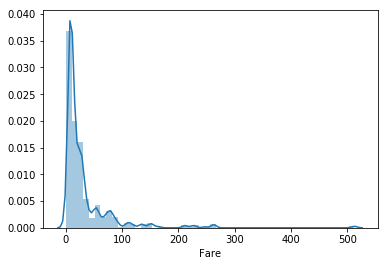

In [28]:
#Verify Distribution
print(train_df["Fare"].value_counts(normalize=True, dropna=False))
sns.distplot(train_df["Fare"].dropna())

In [29]:
#Count missing values
print(train_df["Fare"].isna().sum())

0


Fare já é um valor numérico com uma relação sequencial entre seus valores e por isso não necessita de mais tratamentos. Também não possui missing values.

#### Cabin
Fare representa a cabine atribuída ao passageiro.

In [30]:
#Take a look at the data
print(train_df["Cabin"].value_counts(normalize=True, dropna=False))

NaN            0.771044
B96 B98        0.004489
C23 C25 C27    0.004489
G6             0.004489
C22 C26        0.003367
F2             0.003367
F33            0.003367
D              0.003367
E101           0.003367
C125           0.002245
C126           0.002245
E33            0.002245
B51 B53 B55    0.002245
C68            0.002245
E121           0.002245
E67            0.002245
B77            0.002245
B49            0.002245
B20            0.002245
D26            0.002245
E8             0.002245
C93            0.002245
C92            0.002245
E24            0.002245
E25            0.002245
C83            0.002245
F G73          0.002245
C52            0.002245
D36            0.002245
C124           0.002245
                 ...   
C49            0.001122
B71            0.001122
B38            0.001122
A23            0.001122
E38            0.001122
B82 B84        0.001122
D11            0.001122
A26            0.001122
C128           0.001122
E46            0.001122
B78            0

77% dos passageiros no conjunto de treinamento não possuem informação em relação à cabine em que estavam. 

Quando a maior parte da instâncias não possuem um valor para determinado atributo, é plausível questionar a utilidade de incluí-lo no treinamento do modelo. Por conter uma grande quantidade de missing values, é possível que a feature não traga informacão útil ou até mesmo adicione ruído aos dados, onerando o resultado final. 

O volume de missing values também dificulta o preenchimento dos campos faltantes caso a feature seja utilizada.

#### Embarked
Embarked representa o porto de onde o passageiro embarcou.

In [31]:
#Verify Distribution
print(train_df["Embarked"].value_counts(normalize=True, dropna=False))

S      0.722783
C      0.188552
Q      0.086420
NaN    0.002245
Name: Embarked, dtype: float64


Esta é uma variável categórica que possui missing values. 

O encoding do atributo se dá da mesma maneira que para a feature Sex.

O preenchimento dos missing values pode ser feito de mais de uma forma:
* Atribuindo o valor mais frequente
* Escolhendo um valor aleatório entre os disponíveis, onde a probabilidade de um valor ser escolhido corresponde a porcentagem que ele representa no conjunto de treinamento.

## Feature Engineering
---
Feature Engineering é uma atividade que consiste em criar ou transformar features baseando-se nas que já existem.
Pode ser feito combinando dois ou mais atributos ou ainda modificando atributos que já existem. 

Esta etapa do processo não será apresentada de forma detalhada.

## Outlier Removal
---

## Data Analysis
---